<center><a href="https://www.featuretools.com/"><img src="img/featuretools-logo.png" width="400" height="200" /></a></center>

<h2> An Advanced Featuretools Approach with Custom Primitives</h2>
<p>The following tutorial illustrates an advanced featuretools model for the NYC Taxi Trip Duration competition on Kaggle using our custom primitive API. You will need to download the following five files into a `data` folder in this repository.</p>

<h2>Step 1: Download raw data </h2>
<a href="https://www.kaggle.com/c/nyc-taxi-trip-duration/data">test.csv and train.csv</a>

In [1]:
import featuretools as ft
import pandas as pd
import numpy as np
import taxi_utils

import warnings
warnings.simplefilter('ignore')

ft.__version__

'1.4.0'

<h2>Step 2: Prepare the Data </h2>

In [2]:
TRAIN_DIR = "data/train.csv"
TEST_DIR = "data/test.csv"

data_train, data_test = taxi_utils.read_data(TRAIN_DIR, TEST_DIR)

The `fastest_routes` dataset has information on the shortest path between two coordinates in NYC. We can merge it in with our dataset here and then merge together our test and train datasets after marking them as such.

In [3]:
# Make a train/test column
data_train['test_data'] = False
data_test['test_data'] = True

# Combine the data and convert some strings
data = pd.concat([data_train, data_test], sort=True)
data.head(5)

,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,test_data,trip_duration,vendor_id
0,40.765602,-73.964630,id2875421,1,2016-03-14 17:24:55,40.767937,-73.982155,False,False,455.0,2
1,40.731152,-73.999481,id2377394,1,2016-06-12 00:43:35,40.738564,-73.980415,False,False,663.0,1
2,40.710087,-74.005333,id3858529,1,2016-01-19 11:35:24,40.763939,-73.979027,False,False,2124.0,2
3,40.706718,-74.012268,id3504673,1,2016-04-06 19:32:31,40.719971,-74.010040,False,False,429.0,2
4,40.782520,-73.972923,id2181028,1,2016-03-26 13:30:55,40.793209,-73.973053,False,False,435.0,2


## Step 3: Custom Primitives
The custom primitive API is new to Featuretools version 0.1.9. Our workflow will be as follows:
1. Make a new LatLong class which is a tuple of a latitude and longitude
2. Define some functions for LatLong
3. Make new primitives from those functions

For the first step, we'll make new columns for the pickup and dropoff locations which are tuples.

In [4]:
data["pickup_latlong"] = data[['pickup_latitude', 'pickup_longitude']].apply(tuple, axis=1)
data["dropoff_latlong"] = data[['dropoff_latitude', 'dropoff_longitude']].apply(tuple, axis=1)
data = data.drop(["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"], axis = 1)

We can define the `pickup_latlong` to be a `LatLong` type. This is a way to tell DFS that certain primitives are only important in one direction, from the beginning of a trip to the end. 

In [5]:
from woodwork.logical_types import Ordinal

trip_logical_types = {
    'passenger_count': Ordinal(order=list(range(0, 10))), 
    'vendor_id': 'Categorical',
    'pickup_latlong': 'LatLong',
    'dropoff_latlong': 'LatLong',
}

es = ft.EntitySet("taxi")

es.add_dataframe(dataframe_name="trips",
                 dataframe=data,
                 index="id",
                 time_index='pickup_datetime',
                 logical_types=trip_logical_types)

es.normalize_dataframe(base_dataframe_name="trips",
                       new_dataframe_name="vendors",
                       index="vendor_id")

es.normalize_dataframe(base_dataframe_name="trips",
                       new_dataframe_name="passenger_cnt",
                       index="passenger_count")

cutoff_time = es['trips'][['id', 'pickup_datetime']]

## Visualize EntitySet

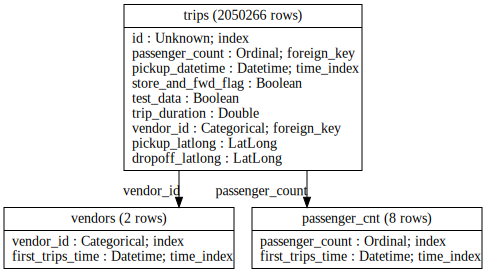

In [6]:
es.plot()

Next, we can create primitives for our new `pickup_latlong` and `dropoff_latlong` which are of type `LatLong`. 

The distance between two `LatLong` types is most accurately represented by the Haversine distance: the nearest length along a sphere. We can also define the Cityblock distance (also called the taxicab metric), which takes into account that we can't move diagonally through buildings in Manhattan.

In [7]:
from featuretools.primitives import make_agg_primitive, make_trans_primitive

def haversine(latlong1, latlong2):
    lat_1s = np.array([x[0] for x in latlong1])
    lon_1s = np.array([x[1] for x in latlong1])
    lat_2s = np.array([x[0] for x in latlong2])
    lon_2s = np.array([x[1] for x in latlong2])
    lon1, lat1, lon2, lat2 = map(np.radians, [lon_1s, lat_1s, lon_2s, lat_2s])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    km = 6367 * 2 * np.arcsin(np.sqrt(a))
    return km

def cityblock(latlong1, latlong2):
    lon_dis = haversine(latlong1, latlong2)
    lat_dist = haversine(latlong1, latlong2)
    return lon_dis + lat_dist

def bearing(latlong1, latlong2):
    lat1 = np.array([x[0] for x in latlong1])
    lon1 = np.array([x[1] for x in latlong1])
    lat2 = np.array([x[0] for x in latlong2])
    lon2 = np.array([x[1] for x in latlong2])
    delta_lon = np.radians(lon2 - lon1)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    x = np.cos(lat2) * np.sin(delta_lon)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon)
    return np.degrees(np.arctan2(x, y))

We can also make some primitives directly from `LatLong` types. In particular, we'll almost certainly want to extract the Latitude, the Longitude and the central point between two such coordinates.

<p>Now lets make primitives from those functions!</p>

In [8]:
from woodwork.column_schema import ColumnSchema
from woodwork.logical_types import Double, LatLong

Bearing = make_trans_primitive(function=bearing,
                               input_types=[ColumnSchema(logical_type=LatLong), ColumnSchema(logical_type=LatLong)],
                               commutative=True,
                               return_type=ColumnSchema(logical_type=Double, semantic_tags={'numeric'}))

Cityblock = make_trans_primitive(function=cityblock,
                                 input_types=[ColumnSchema(logical_type=LatLong), ColumnSchema(logical_type=LatLong)],
                                 commutative=True,
                                 return_type=ColumnSchema(logical_type=Double, semantic_tags={'numeric'}))

In [9]:
from woodwork.logical_types import Datetime, Boolean

def is_rush_hour(datetime):
    hour = pd.DatetimeIndex(datetime).hour
    return (hour >= 7) & (hour <= 11)

def is_noon_hour(datetime):
    hour = pd.DatetimeIndex(datetime).hour
    return (hour >= 11) & (hour <= 13)

def is_night_hour(datetime):
    hour = pd.DatetimeIndex(datetime).hour
    return (hour >= 18) & (hour <= 23)

RushHour = make_trans_primitive(function=is_rush_hour,
                                input_types=[ColumnSchema(logical_type=Datetime)],
                                return_type = ColumnSchema(logical_type=Boolean))
    
NoonHour = make_trans_primitive(function=is_noon_hour,
                                input_types=[ColumnSchema(logical_type=Datetime)],
                                return_type = ColumnSchema(logical_type=Boolean))
        
NightHour = make_trans_primitive(function=is_night_hour,
                                 input_types=[ColumnSchema(logical_type=Datetime)],
                                 return_type = ColumnSchema(logical_type=Boolean))

We have grouped together some times of day with `RushHour`, `NoonHour` and `NightHour`.

In [10]:
from featuretools.primitives import TransformPrimitive
from woodwork.logical_types import Boolean, LatLong

class GeoBox(TransformPrimitive):
    name = "GeoBox"
    input_types=[ColumnSchema(logical_type=LatLong)]
    return_type=ColumnSchema(logical_type=Boolean)
    
    def __init__(self, bottomleft, topright):
        self.bottomleft = bottomleft
        self.topright = topright
    
    def get_function(self):
        def geobox(latlong, bottomleft=self.bottomleft, topright=self.topright):
            lat = np.array([x[0] for x in latlong])
            lon = np.array([x[1] for x in latlong])
            boxlats = [bottomleft[0],topright[0]]
            boxlongs = [bottomleft[1], topright[1]]
            output = []
            for i, name in enumerate(lat):
                if (min(boxlats) <= lat[i] and lat[i] <= max(boxlats) and 
                        min(boxlongs) <= lon[i] and lon[i] <= max(boxlongs)):
                    output.append(True)
                else: 
                    output.append(False)
            return output
        
        return geobox

    def generate_name(self, base_feature_names):
        return u"GEOBOX({}, {}, {})".format(base_feature_names[0],
                                            str(self.bottomleft),
                                            str(self.topright))

The feature `Geobox` finds if a latlong is in a rectangle defined by two coordinate pairs.

## Step 4: Using custom primitives in DFS

Let's see what features are created if we run DFS now:

In [11]:
agg_primitives = []
trans_primitives = [Bearing, Cityblock,
                    GeoBox(bottomleft=(40.62, -73.85), topright=(40.70, -73.75)),
                    GeoBox(bottomleft=(40.70, -73.97), topright=(40.77, -73.9)),
                    RushHour,
                    NoonHour,
                    NightHour]

# calculate feature_matrix using deep feature synthesis
features = ft.dfs(entityset=es,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=agg_primitives,
                  drop_contains=['trips.test_data'],
                  verbose=True,
                  cutoff_time=cutoff_time,
                  approximate='36d',
                  max_depth=3,
                  max_features=40,
                  features_only=True)
features

Built 20 features


[<Feature: passenger_count>,
 <Feature: store_and_fwd_flag>,
 <Feature: test_data>,
 <Feature: trip_duration>,
 <Feature: vendor_id>,
 <Feature: GEOBOX(dropoff_latlong, (40.62, -73.85), (40.7, -73.75))>,
 <Feature: GEOBOX(pickup_latlong, (40.62, -73.85), (40.7, -73.75))>,
 <Feature: GEOBOX(dropoff_latlong, (40.7, -73.97), (40.77, -73.9))>,
 <Feature: GEOBOX(pickup_latlong, (40.7, -73.97), (40.77, -73.9))>,
 <Feature: BEARING(dropoff_latlong, pickup_latlong)>,
 <Feature: CITYBLOCK(dropoff_latlong, pickup_latlong)>,
 <Feature: IS_NIGHT_HOUR(pickup_datetime)>,
 <Feature: IS_NOON_HOUR(pickup_datetime)>,
 <Feature: IS_RUSH_HOUR(pickup_datetime)>,
 <Feature: vendors.IS_NIGHT_HOUR(first_trips_time)>,
 <Feature: vendors.IS_NOON_HOUR(first_trips_time)>,
 <Feature: vendors.IS_RUSH_HOUR(first_trips_time)>,
 <Feature: passenger_cnt.IS_NIGHT_HOUR(first_trips_time)>,
 <Feature: passenger_cnt.IS_NOON_HOUR(first_trips_time)>,
 <Feature: passenger_cnt.IS_RUSH_HOUR(first_trips_time)>]

Our new features were applied exactly where they should be! The distances were only calcuated between the pickup_latlong and the dropoff_latlong, while primitives like `LATITUDE` were calculated on both latlong columns.

For this dataset, we have approximately 2 million distinct cutoff times, times at which DFS will have to recalculate aggregation primitives. Calculating those features at specific times every hour and using that number instead will save computation time and perhaps not lose too much information. The `approximate` parameter in DFS lets you specify a window size to use when approximating.

With the features from before, we calculate the whole feature matrix:

In [12]:
agg_primitives = ['Sum', 'Mean', 'Median', 'Std', 'Count', 'Min', 'Max', 'Num_Unique', 'Skew']
trans_primitives = [Bearing, Cityblock,
                    GeoBox(bottomleft=(40.62, -73.85), topright=(40.70, -73.75)),
                    GeoBox(bottomleft=(40.70, -73.97), topright=(40.77, -73.9)),
                    RushHour,
                    NoonHour,
                    NightHour,
                    'Day', 'Hour', 'Minute', 'Month', 'Weekday', 'Week', 'Is_weekend']

# this allows us to create features that are conditioned on a second value before we calculate.
es.add_interesting_values()

# calculate feature_matrix using deep feature synthesis
feature_matrix, features = ft.dfs(entityset=es,
                                  target_dataframe_name="trips",
                                  trans_primitives=trans_primitives,
                                  agg_primitives=agg_primitives,
                                  drop_contains=['trips.test_data'],
                                  verbose=True,
                                  cutoff_time=cutoff_time,
                                  approximate='36d',
                                  max_depth=4)

feature_matrix.head()

Built 99 features
Elapsed: 03:51 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████


,passenger_count,store_and_fwd_flag,test_data,trip_duration,vendor_id,"GEOBOX(dropoff_latlong, (40.62, -73.85), (40.7, -73.75))","GEOBOX(pickup_latlong, (40.62, -73.85), (40.7, -73.75))","GEOBOX(dropoff_latlong, (40.7, -73.97), (40.77, -73.9))","GEOBOX(pickup_latlong, (40.7, -73.97), (40.77, -73.9))","BEARING(dropoff_latlong, pickup_latlong)",...,passenger_cnt.NUM_UNIQUE(trips.MINUTE(pickup_datetime)),passenger_cnt.NUM_UNIQUE(trips.MONTH(pickup_datetime)),passenger_cnt.NUM_UNIQUE(trips.WEEK(pickup_datetime)),passenger_cnt.NUM_UNIQUE(trips.WEEKDAY(pickup_datetime)),"passenger_cnt.SKEW(trips.BEARING(dropoff_latlong, pickup_latlong))","passenger_cnt.SKEW(trips.CITYBLOCK(dropoff_latlong, pickup_latlong))","passenger_cnt.STD(trips.BEARING(dropoff_latlong, pickup_latlong))","passenger_cnt.STD(trips.CITYBLOCK(dropoff_latlong, pickup_latlong))","passenger_cnt.SUM(trips.BEARING(dropoff_latlong, pickup_latlong))","passenger_cnt.SUM(trips.CITYBLOCK(dropoff_latlong, pickup_latlong))"
id,,,,,,,,,,,,,,,,,,,,,
id0190469,5,False,False,849.0,2,False,False,False,False,-163.529609,...,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,0.0,0.0
id0621643,2,False,True,NaN,2,False,False,True,False,-169.753936,...,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,0.0,0.0
id1384355,1,False,True,NaN,1,False,False,False,False,-149.644870,...,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,0.0,0.0
id1665586,1,False,False,1294.0,1,False,False,True,False,-34.622058,...,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,0.0,0.0
id1210365,5,False,False,408.0,2,False,False,False,False,-136.358219,...,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,0.0,0.0


## Step 5: Build the Model







<p>As before, we need to retrieve our labels for the train dataset, so we should merge our current feature matrix with the original dataset. </p>

<p>We use the `log` of the trip duration since that measure is better at distinguishing distances within the city</p>

Just like in the previous notebook, we will perform the modeling with [EvalML](https://evalml.alteryx.com/en/stable/)
<p align="center">
<img width=50% src="https://evalml-web-images.s3.amazonaws.com/evalml_horizontal.svg" alt="Featuretools" />
</p>


In [13]:
# separates the whole feature matrix into train data feature matrix, train data labels, and test data feature matrix 
X_train, labels, X_test = taxi_utils.get_train_test_fm(feature_matrix)
labels = np.log(labels.values + 1)

In [14]:
import evalml
from evalml import AutoMLSearch

automl = AutoMLSearch(X_train=X_train,
                      y_train=labels,
                      problem_type="regression",
                      objective="root mean squared error")
automl.search()

In [15]:
pipeline = automl.best_pipeline
pipeline.fit(X_train, labels)

pipeline = RegressionPipeline(component_graph={'Replace Nullable Types Transformer': ['Replace Nullable Types Transformer', 'X', 'y'], 'Imputer': ['Imputer', 'Replace Nullable Types Transformer.x', 'Replace Nullable Types Transformer.y'], 'One Hot Encoder': ['One Hot Encoder', 'Imputer.x', 'Replace Nullable Types Transformer.y'], 'XGBoost Regressor': ['XGBoost Regressor', 'One Hot Encoder.x', 'Replace Nullable Types Transformer.y']}, parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'One Hot Encoder':{'top_n': 10, 'features_to_encode': None, 'categories': None, 'drop': 'if_binary', 'handle_unknown': 'ignore', 'handle_missing': 'error'}, 'XGBoost Regressor':{'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'n_jobs': -1}}, random_seed=0)

Notice that by combining EvalML and the custom primitives, we were able to create a model with an even lower RMSE. This is the power of feature engineering combined with auto modeling

In [16]:
submission = pipeline.predict(X_test)
submission.head(5)

id
id0621643    6.973404
id1384355    7.461643
id2568735    7.124558
id3700764    6.971888
id3008929    5.559479
dtype: float64

<p align="center">
<img width=50% src="https://alteryx-open-source-images.s3.amazonaws.com/OpenSource_Logo-01.jpg" alt="ayx_os" />
</p>

Featuretools was created by the developers at [Alteryx](https://www.alteryx.com). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.alteryx.com/contact-us/).